LSTM TextCNN
--

In [1]:
import sys
sys.path.append("../")

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import callbacks, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM, Dense, Dropout, Activation, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import clean_text
from utils.metrics import Metrics, Report

# Import Data

In [2]:
data_path = '../../data/'

In [3]:
with open(data_path + 'categories_string.csv') as f:
    categories = dict(map(lambda x:x.strip('\n').split(',')[::-1], f.readlines()[1:]))

X = pd.read_json(data_path + 'train.json').set_index('Id')
y = pd.read_csv(data_path + 'train_label.csv', index_col='Id', dtype={'Category': 'category'}).Category

# Preparing data
Words number per X

<AxesSubplot:>

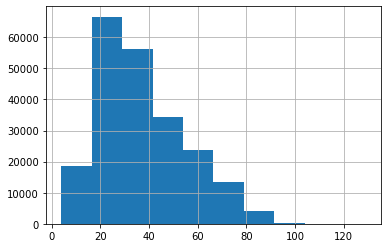

In [4]:
X['gender_name'] = X.gender
X.gender = X.loc[:, 'gender'].astype('category').cat.codes.rename("gender_cat")
X.description = X.description.apply(clean_text)

X.description.apply(lambda x:x.split().__len__()).hist()

Split to train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 1/3, random_state=42069)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### Global features and hyper params dimension

In [6]:
vocab_size = 1000
sequences_length = 80
embedding_dimensionality = 64
max_features = vocab_size
input_length = sequences_length + 1

num_labels = 28
batch_size = 512
nb_epoch = 18

nof_filters = 200
kernel_size = 16

hidden_dims = 1024

## Processing X
Converting description to word sequence.  
Adding `gender` categorical feature to `x`.

In [7]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train.description)

In [8]:
desc_train = tokenizer.texts_to_sequences(X_train.description)
desc_test = tokenizer.texts_to_sequences(X_test.description)

desc_train = sequence.pad_sequences(desc_train, maxlen = sequences_length, padding = 'post')
desc_test = sequence.pad_sequences(desc_test, maxlen = sequences_length, padding = 'post')

In [9]:
x_train = concatenate([desc_train, X_train.gender.to_numpy('int32').reshape((-1,1))])
x_test = concatenate([desc_test, X_test.gender.to_numpy('int32').reshape((-1,1))])

## Processing Y
Convert Y to matrix

In [10]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Model
Embedding + LSTM + CNN

## Training

In [11]:
model = Sequential()

model.add(Embedding(max_features, embedding_dimensionality, input_length=input_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides = 1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(.3))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 64)            64000     
_________________________________________________________________
lstm (LSTM)                  (None, 81, 100)           66000     
_________________________________________________________________
conv1d (Conv1D)              (None, 66, 200)           320200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205824    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0

Compile and fit model.  
Accuracy is observed on validation set *(20%)*.
F1 score will be observed on the test set.

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

with tf.device('/gpu:0'):
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        verbose=1,
        validation_split = .2,
        use_multiprocessing = True
    )

Train on 115838 samples, validate on 28960 samples
Epoch 1/18
115838/115838 [==============================] - 52s 452us/sample - loss: 1.6374 - acc: 0.5389 - val_loss: 1.0583 - val_acc: 0.6958
Epoch 2/18
115838/115838 [==============================] - 47s 406us/sample - loss: 0.9796 - acc: 0.7170 - val_loss: 0.8814 - val_acc: 0.7438ss: 0.9818 - acc: 0.71 - ETA: 0s - loss: 0.9810 - acc: 0.
Epoch 3/18
115838/115838 [==============================] - 47s 408us/sample - loss: 0.8672 - acc: 0.7452 - val_loss: 0.8211 - val_acc: 0.7603
Epoch 4/18
115838/115838 [==============================] - 47s 407us/sample - loss: 0.8170 - acc: 0.7587 - val_loss: 0.8033 - val_acc: 0.7612
Epoch 5/18
115838/115838 [==============================] - 47s 406us/sample - loss: 0.7753 - acc: 0.7678 - val_loss: 0.7687 - val_acc: 0.7719
Epoch 6/18
115838/115838 [==============================] - 48s 410us/sample - loss: 0.7431 - acc: 0.7758 - val_loss: 0.7623 - val_acc: 0.7732
Epoch 7/18
115838/115838 [========

Accuracy score evolution by epochs

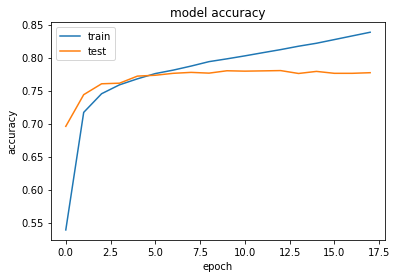

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss evolution by epochs

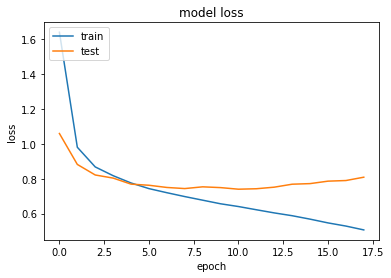

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating

In [15]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Categorical crossentropy:', score[0])
print('Categorical accuracy:', score[1])

72399/72399 [==============================] - 9s 123us/sample - loss: 0.8286 - acc: 0.7708
Categorical crossentropy: 0.828601825624051
Categorical accuracy: 0.7707565


In [16]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis = 1)

report = Report(
    array_result = np.array([
        y_true.tolist(),
        y_pred.tolist(),
        X_test.gender_name.to_list()
    ]), categories = categories
)

print(report)

                   precision    recall  f1-score   diff_di   support

           pastor      0.643     0.404     0.496     1.063       312
            model      0.758     0.631     0.689     5.360      3465
               dj      0.746     0.661     0.701     0.151      3815
        physician      0.709     0.492     0.581     0.008       297
         comedian      0.722     0.618     0.666     0.975       319
software_engineer      0.659     0.672     0.666     0.042      4144
            nurse      0.778     0.734     0.755    14.048       758
             poet      0.813     0.856     0.834     0.329      4902
          dentist      0.880     0.924     0.901     4.747      1826
     chiropractor      0.748     0.710     0.728     0.404      1377
        filmmaker      0.427     0.392     0.409     0.069       487
        professor      0.540     0.542     0.541     0.012      3065
     yoga_teacher      0.742     0.665     0.701     0.247      1337
     photographer      0.767     